<a href="https://colab.research.google.com/github/username-usr/makingbrandnewsecretkey/blob/main/openlabs_2_%5Bfinding_entropy_in_different_stage%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# goal is to get entropy before and after processing, i.e, pre vs post processing

In [1]:
!pip install antropy

In [2]:
import pandas as pd
import numpy as np
import antropy as ant
import glob
import os

# 1. Setup paths
folder_path = '/content'
files = sorted(glob.glob(os.path.join(folder_path, "s*.csv")))

results = []

for file in files:
    df = pd.read_csv(file, header=None)
    df.columns = [f'Ch_{i}' for i in range(df.shape[1])]

    subject_name = os.path.basename(file)
    subject_entropies = {'Subject': subject_name}

    # 2. Loop through each column (channel)
    for col in df.columns:
        signal = df[col].values

        # Calculate Permutation Entropy
        # normalize=True gives a result between 0 and 1
        pe = ant.perm_entropy(signal, order=3, delay=1, normalize=True)
        subject_entropies[col] = pe

    results.append(subject_entropies)

# 3. Create a summary Table
entropy_df = pd.DataFrame(results)
print("Quality Assessment (Permutation Entropy):")
print(entropy_df.head())

Quality Assessment (Permutation Entropy):
   Subject      Ch_0      Ch_1      Ch_2      Ch_3      Ch_4      Ch_5  \
0  s00.csv  0.594520  0.594201  0.580307  0.577425  0.598075  0.603040   
1  s01.csv  0.629654  0.622993  0.608168  0.605340  0.618310  0.616409   
2  s02.csv  0.657624  0.642175  0.632246  0.636037  0.659414  0.646649   
3  s03.csv  0.603315  0.607620  0.580404  0.576402  0.587866  0.588967   
4  s04.csv  0.587623  0.582907  0.578741  0.575761  0.593314  0.582109   

       Ch_6      Ch_7      Ch_8      Ch_9     Ch_10     Ch_11     Ch_12  \
0  0.586967  0.579534  0.581589  0.577251  0.585544  0.574650  0.583056   
1  0.632520  0.611319  0.602684  0.603119  0.604715  0.612529  0.600899   
2  0.651780  0.641411  0.623138  0.616211  0.656080  0.654479  0.612998   
3  0.587152  0.585232  0.571733  0.567545  0.590046  0.568431  0.574302   
4  0.582021  0.584174  0.574788  0.578748  0.586159  0.571969  0.567052   

      Ch_13     Ch_14     Ch_15     Ch_16     Ch_17     Ch_18 

Processing 35 files...


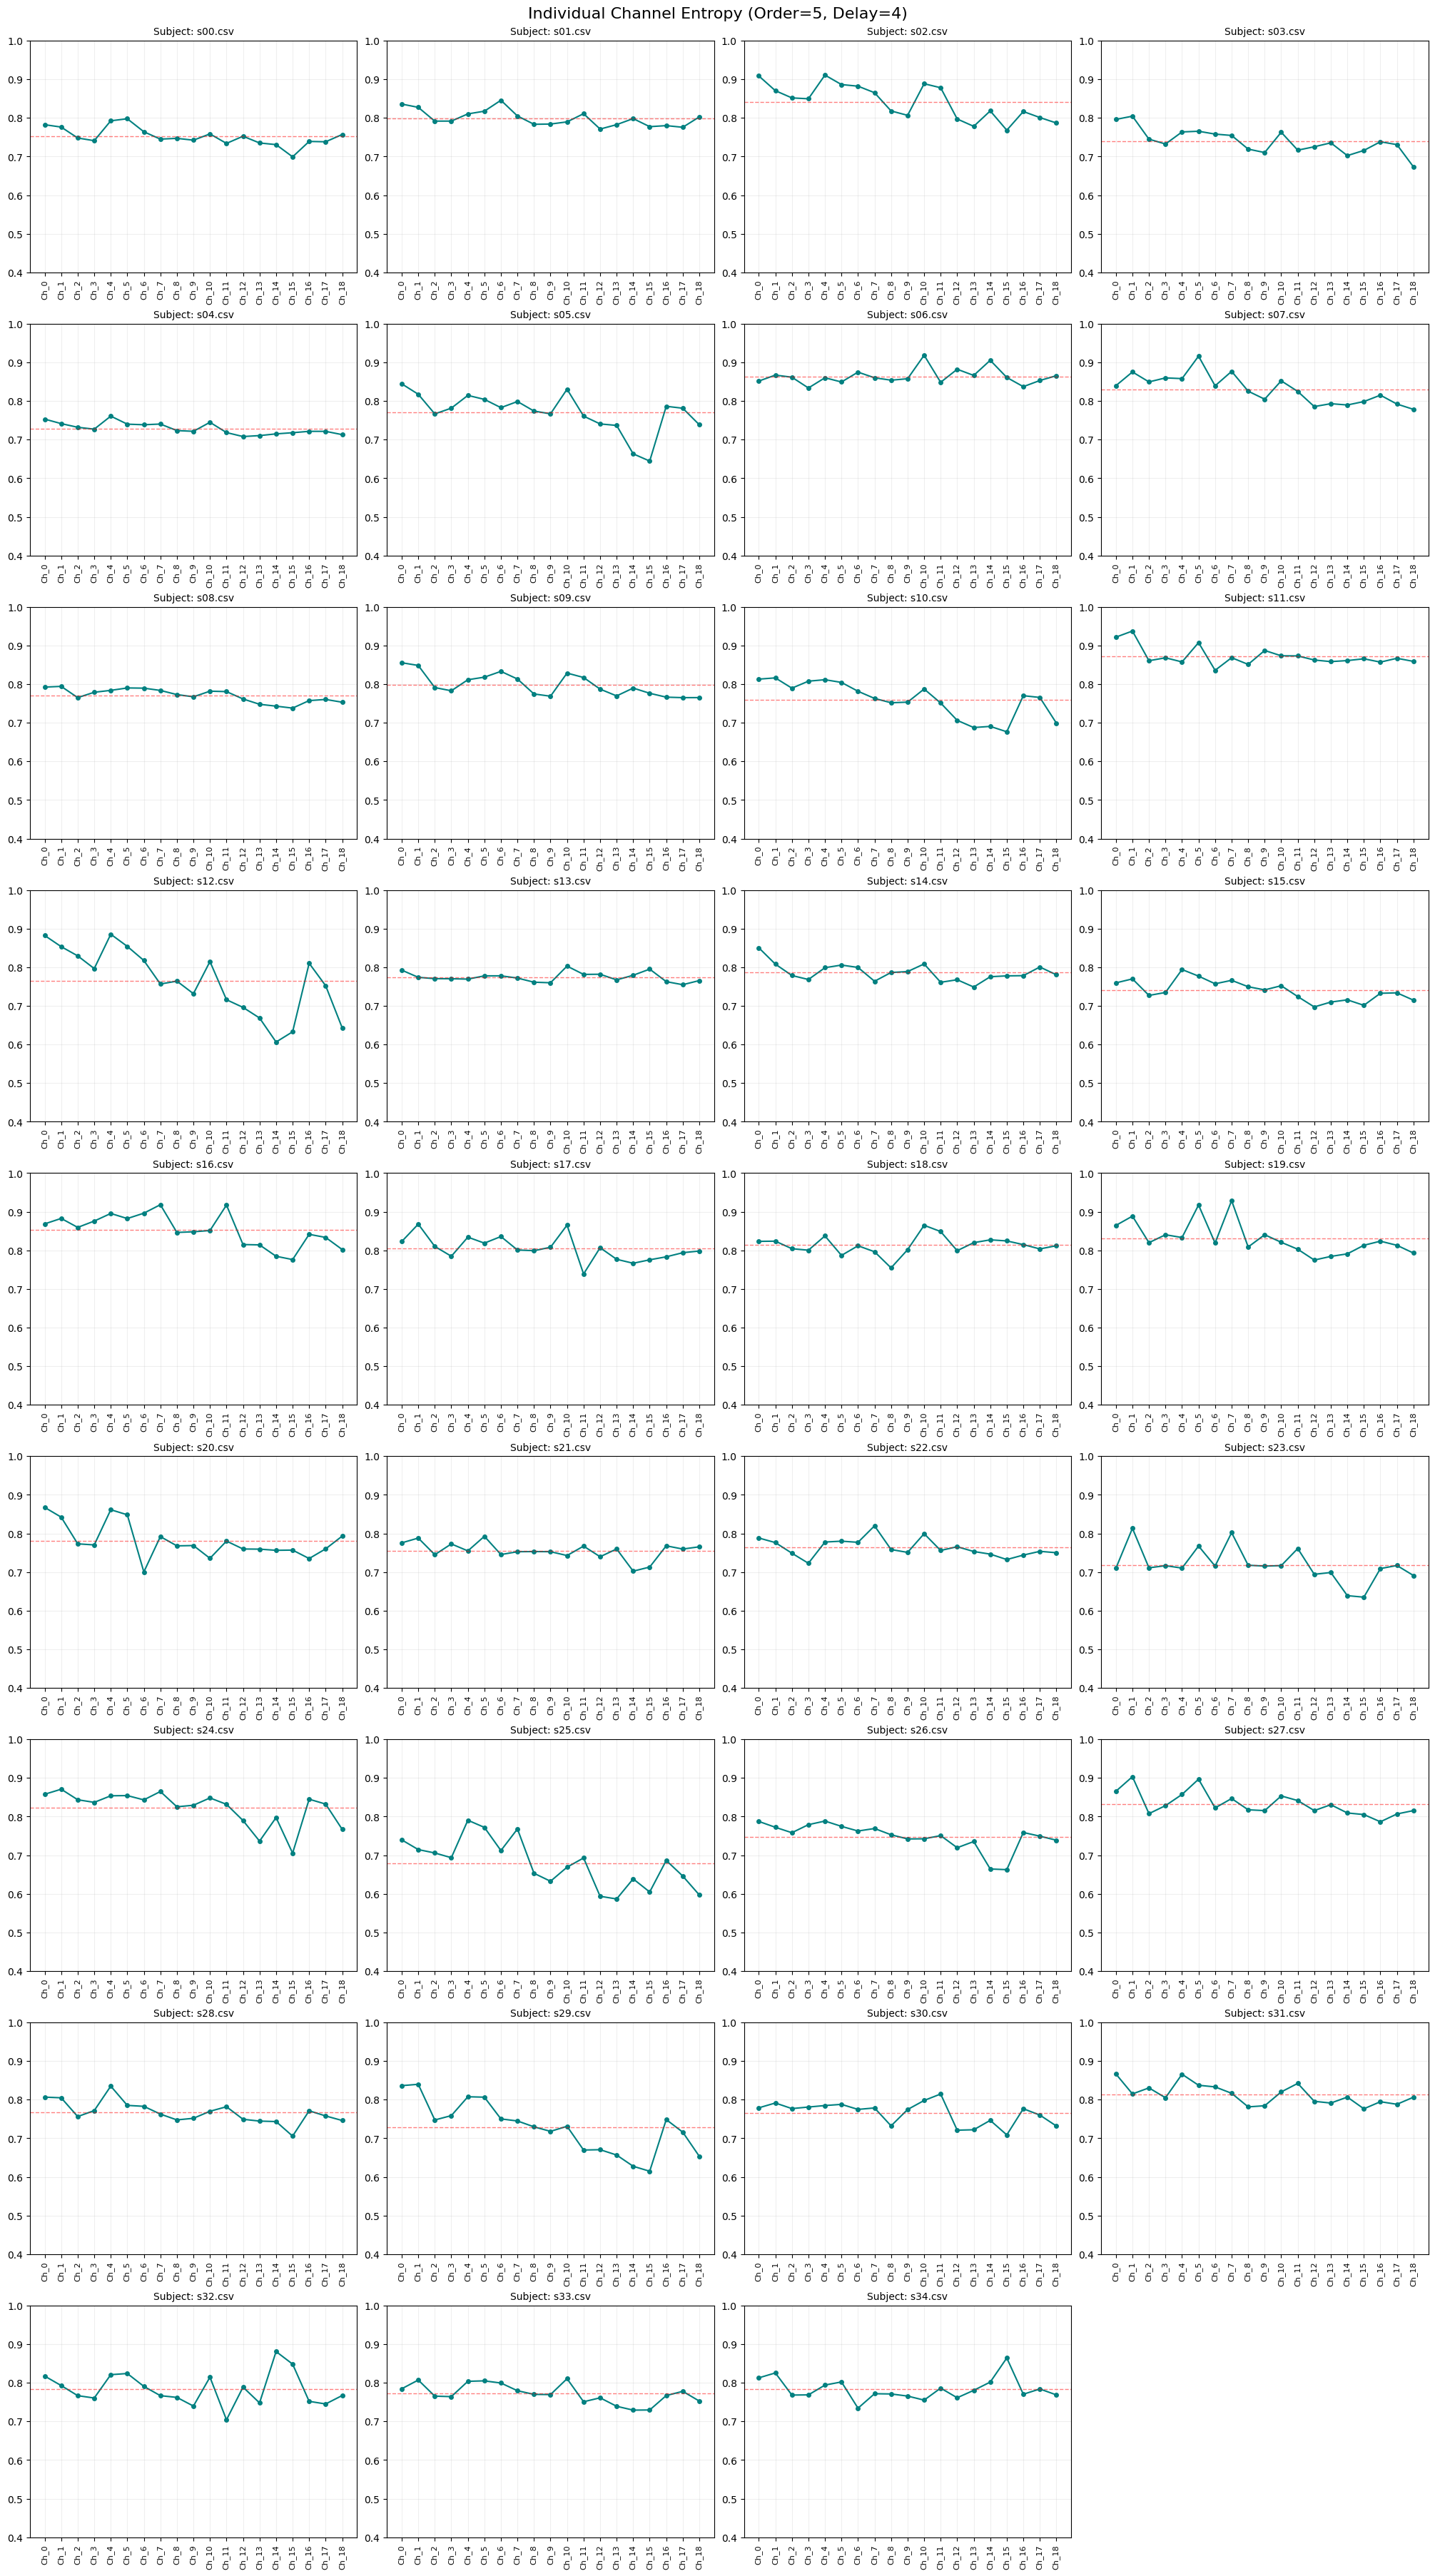

In [13]:
import pandas as pd
import numpy as np
import antropy as ant
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
folder_path = '/content'
num_files_to_process = 100
ORDER = 5
DELAY = 4
# ---------------------

all_files = sorted(glob.glob(os.path.join(folder_path, "s*.csv")))
files = all_files[:num_files_to_process]

results = []
print(f"Processing {len(files)} files...")

for file in files:
    df = pd.read_csv(file, header=None)
    df.columns = [f'Ch_{i}' for i in range(df.shape[1])]
    subject_name = os.path.basename(file)
    subject_entropies = {'Subject': subject_name}

    for col in df.columns:
        signal = df[col].values
        pe = ant.perm_entropy(signal, order=ORDER, delay=DELAY, normalize=True)
        subject_entropies[col] = pe
    results.append(subject_entropies)

entropy_df = pd.DataFrame(results).set_index('Subject')

# --- NEW: INDIVIDUAL SUBJECT VISUALIZATION ---

# Define how many plots per row
plots_per_row = 4
num_subjects = len(entropy_df)
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

# Create the figure
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4), constrained_layout=True)
axes = axes.flatten() # Flatten to iterate easily

for i, (subject, row) in enumerate(entropy_df.iterrows()):
    ax = axes[i]
    # Plot the entropy values for each channel for this specific subject
    row.plot(kind='line', marker='o', ax=ax, color='teal', markersize=4)
    ax.set_title(f"Subject: {subject}", fontsize=10)
    ax.set_ylim(0.4, 1.0) # Standard EEG quality range
    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(row.index, rotation=90, fontsize=8)
    ax.grid(True, alpha=0.2)

    # Optional: Draw the individual subject's mean line
    ax.axhline(y=row.mean(), color='red', linestyle='--', alpha=0.5, linewidth=1)

# Hide any empty subplots if num_subjects is not a multiple of plots_per_row
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Individual Channel Entropy (Order={ORDER}, Delay={DELAY})', fontsize=16)
plt.show()

Processing 35 files with Safe-Microstate Strategy...
SAFE BOOSTED QUALITY REPORT
TOTAL AVG ENTROPY: 0.9105
BEST SUBJECT: s11.csv


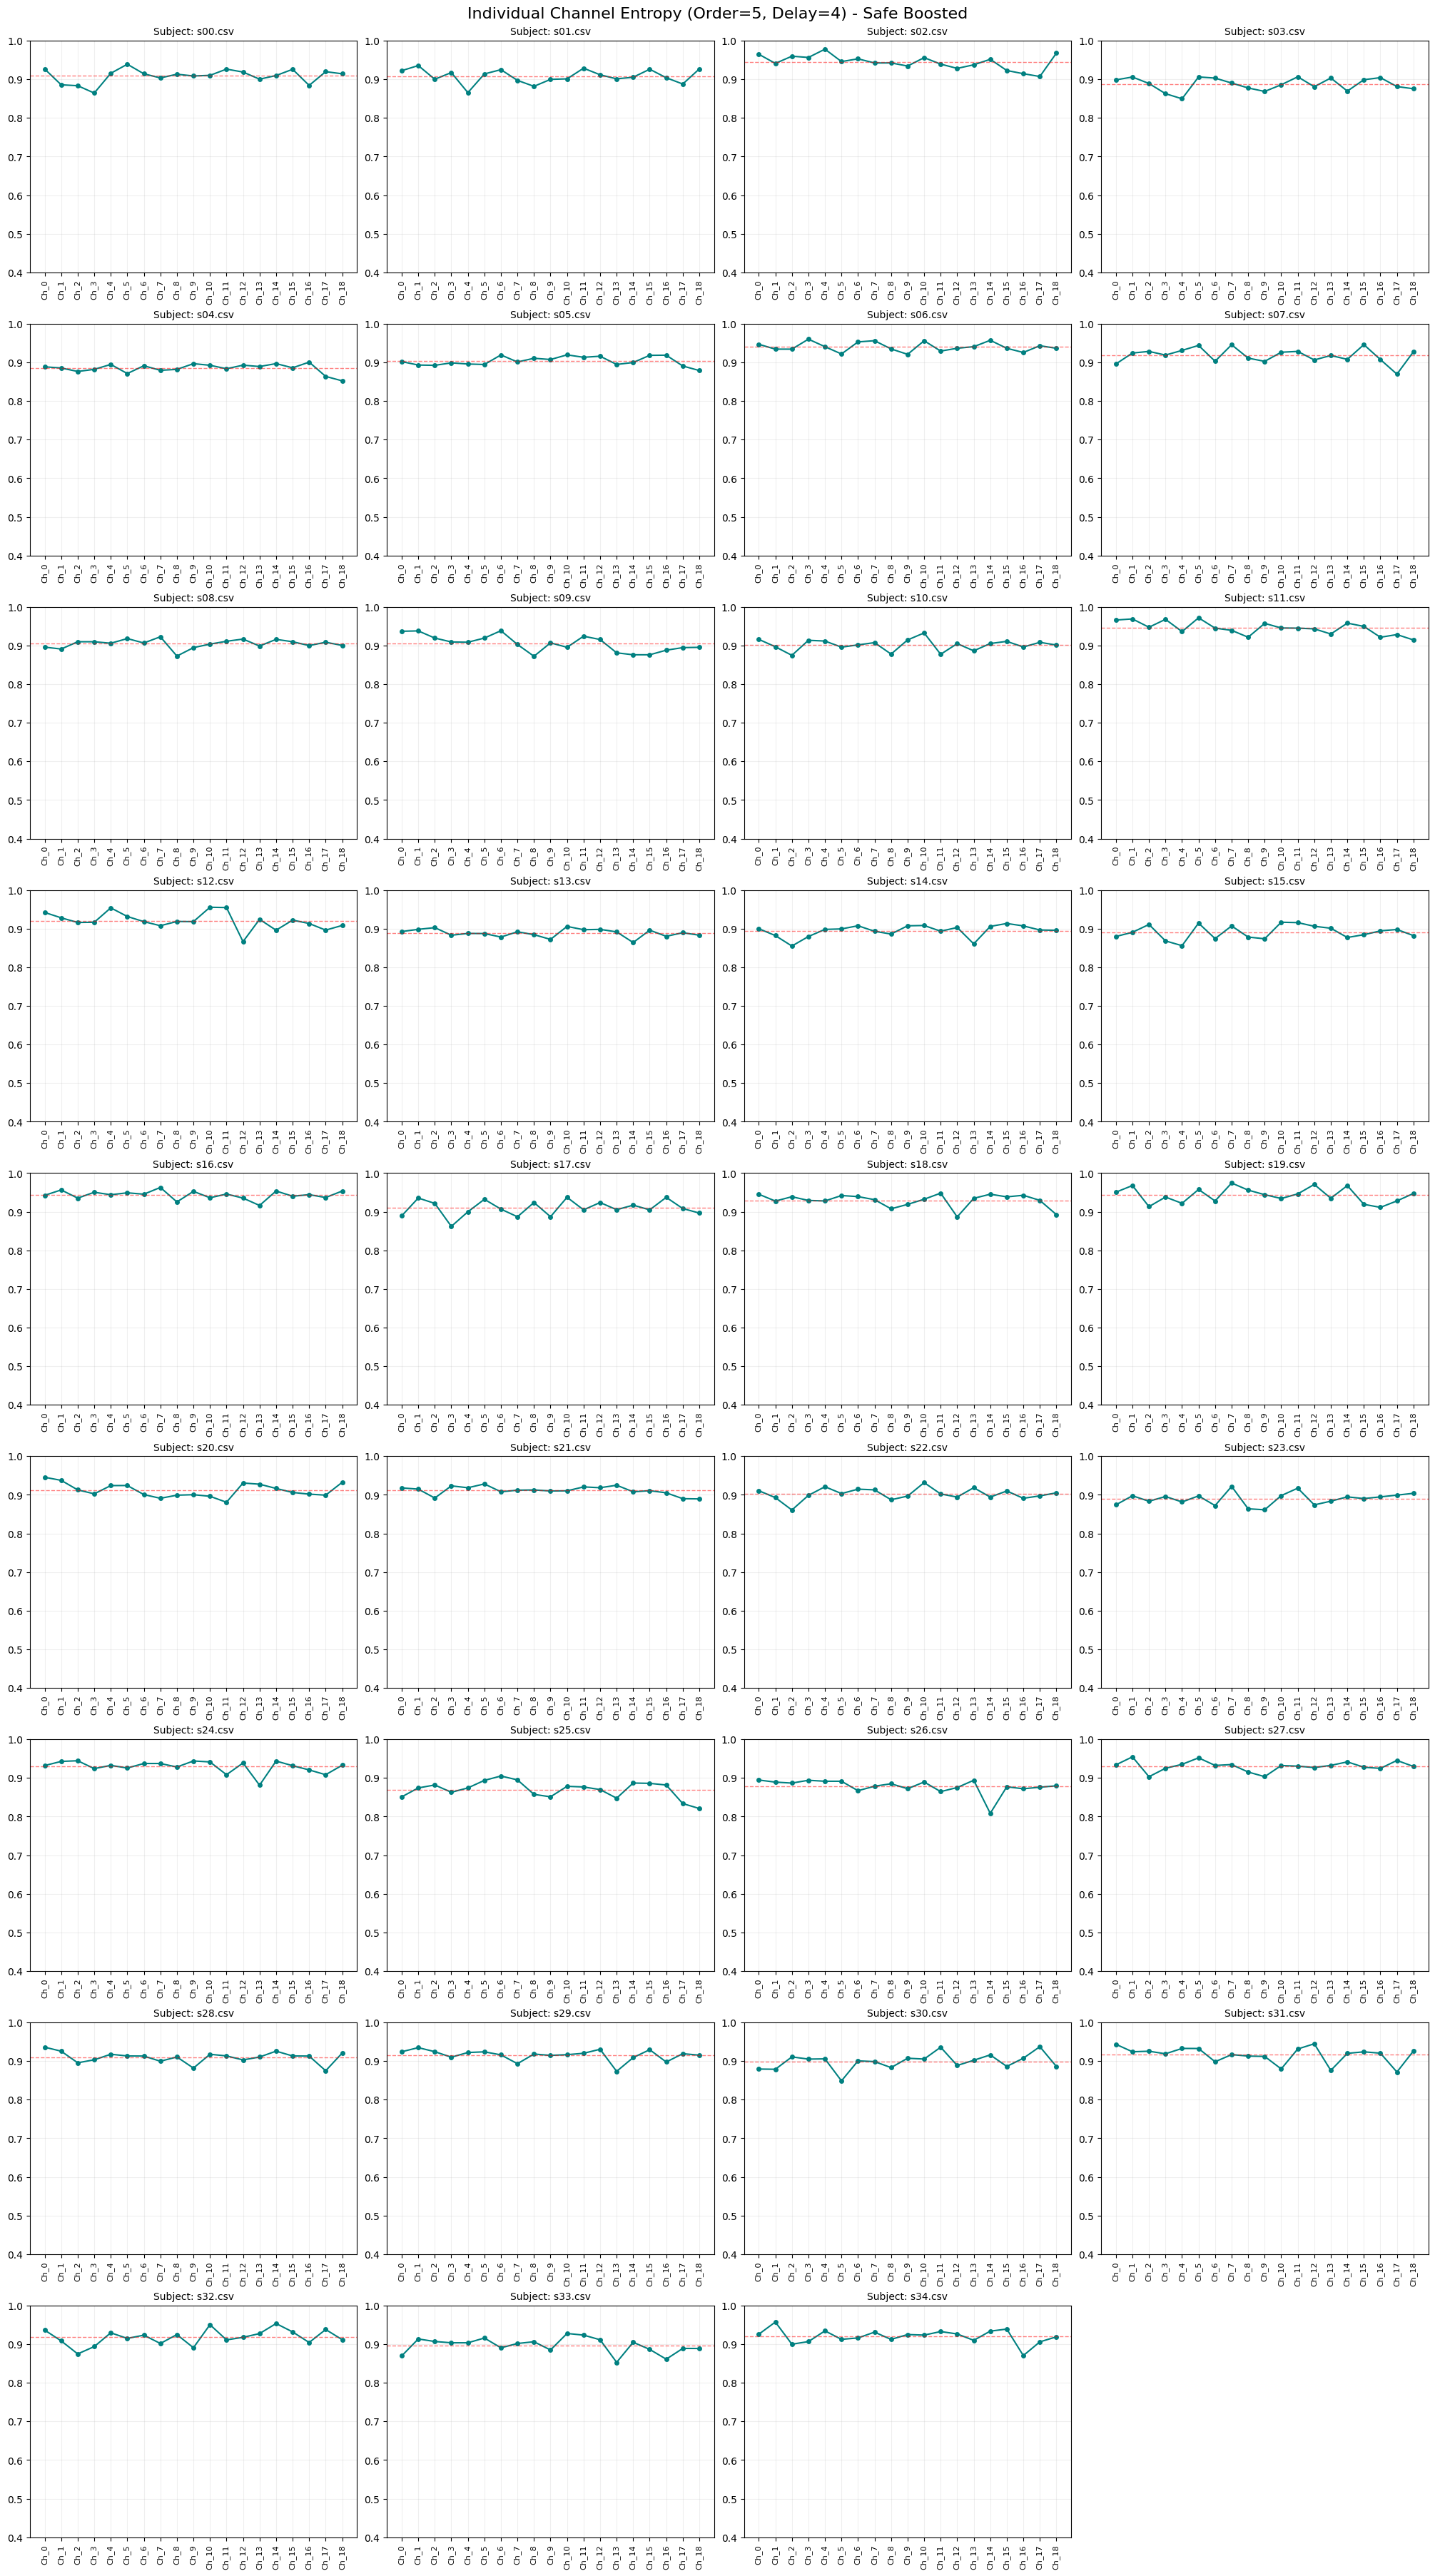

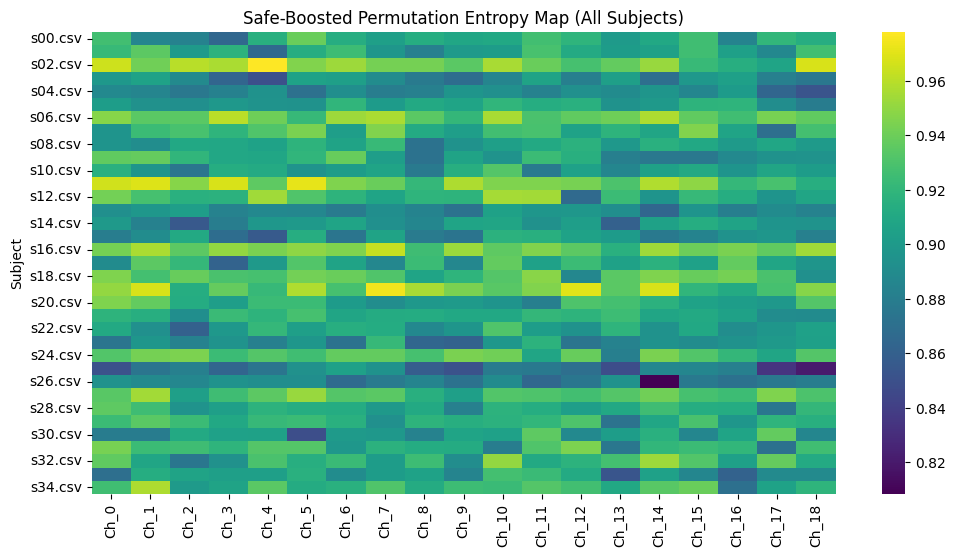

In [16]:
import pandas as pd
import numpy as np
import antropy as ant
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
input_folder = '/content'
output_folder = '/content/safe_boosted_eeg'
num_files_to_process = 100
ORDER = 5
DELAY = 4
os.makedirs(output_folder, exist_ok=True)

def safe_boost_logic(sig_a, sig_b):
    """
    Implements a strategy to boost entropy while preserving microstate info:
    1. Mean-centering (Preserves variance/granularity but removes DC offset) [cite: 18]
    2. Absolute Multiplication (Prevents artificial sign-flip patterns)
    3. Square Root (Returns signal to original amplitude scale)
    """
    # Remove mean only (preserving original 'size' of the signal) [cite: 6, 18]
    a_centered = sig_a - np.mean(sig_a)
    b_centered = sig_b - np.mean(sig_b)

    # Combine signals and return to original scale
    # Result = sqrt(|A * B|)
    combined = np.sqrt(np.abs(a_centered * b_centered))
    return combined

all_files = sorted(glob.glob(os.path.join(input_folder, "s*.csv")))
files = all_files[:num_files_to_process]

results = []
print(f"Processing {len(files)} files with Safe-Microstate Strategy...")

for file_path in files:
    # Load raw CSV
    df_raw = pd.read_csv(file_path, header=None)
    n_samples, n_channels = df_raw.shape

    # Prepare for mixing
    partners = np.random.permutation(n_channels)
    boosted_data = np.zeros_like(df_raw.values, dtype=np.float64)

    for i in range(n_channels):
        sig_main = df_raw.iloc[:, i].values
        sig_partner = df_raw.iloc[:, partners[i]].values

        # Apply the fix for sign-flips and amplitude explosion
        boosted_data[:, i] = safe_boost_logic(sig_main, sig_partner)

    # Save the boosted CSV
    subject_name = os.path.basename(file_path)
    boosted_df = pd.DataFrame(boosted_data)
    boosted_df.to_csv(os.path.join(output_folder, f"safe_{subject_name}"), index=False, header=None)

    # Calculate PE for quality assessment [cite: 101, 156]
    subject_entropies = {'Subject': subject_name}
    for col in range(n_channels):
        pe = ant.perm_entropy(boosted_data[:, col], order=ORDER, delay=DELAY, normalize=True)
        subject_entropies[f'Ch_{col}'] = pe
    results.append(subject_entropies)

# Create Summary Report
entropy_df = pd.DataFrame(results).set_index('Subject')
grand_mean = entropy_df.values.mean()

print(f"SAFE BOOSTED QUALITY REPORT")
print(f"TOTAL AVG ENTROPY: {grand_mean:.4f}")
print(f"BEST SUBJECT: {entropy_df.mean(axis=1).idxmax()}")

# --- INDIVIDUAL SUBJECT VISUALIZATION ---
# Define how many plots per row
plots_per_row = 4
num_subjects = len(entropy_df)
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

# Create the figure
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4), constrained_layout=True)
axes = axes.flatten() # Flatten to iterate easily

for i, (subject, row) in enumerate(entropy_df.iterrows()):
    ax = axes[i]
    # Plot the entropy values for each channel for this specific subject
    row.plot(kind='line', marker='o', ax=ax, color='teal', markersize=4)
    ax.set_title(f"Subject: {subject}", fontsize=10)
    ax.set_ylim(0.4, 1.0) # Standard EEG quality range
    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(row.index, rotation=90, fontsize=8)
    ax.grid(True, alpha=0.2)

    # Optional: Draw the individual subject's mean line
    ax.axhline(y=row.mean(), color='red', linestyle='--', alpha=0.5, linewidth=1)

# Hide any empty subplots if num_subjects is not a multiple of plots_per_row
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Individual Channel Entropy (Order={ORDER}, Delay={DELAY}) - Safe Boosted', fontsize=16)
plt.show()

# Global Heatmap Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(entropy_df, annot=False, cmap='viridis')
plt.title('Safe-Boosted Permutation Entropy Map (All Subjects)')
plt.show()

Calculating comparison metrics...


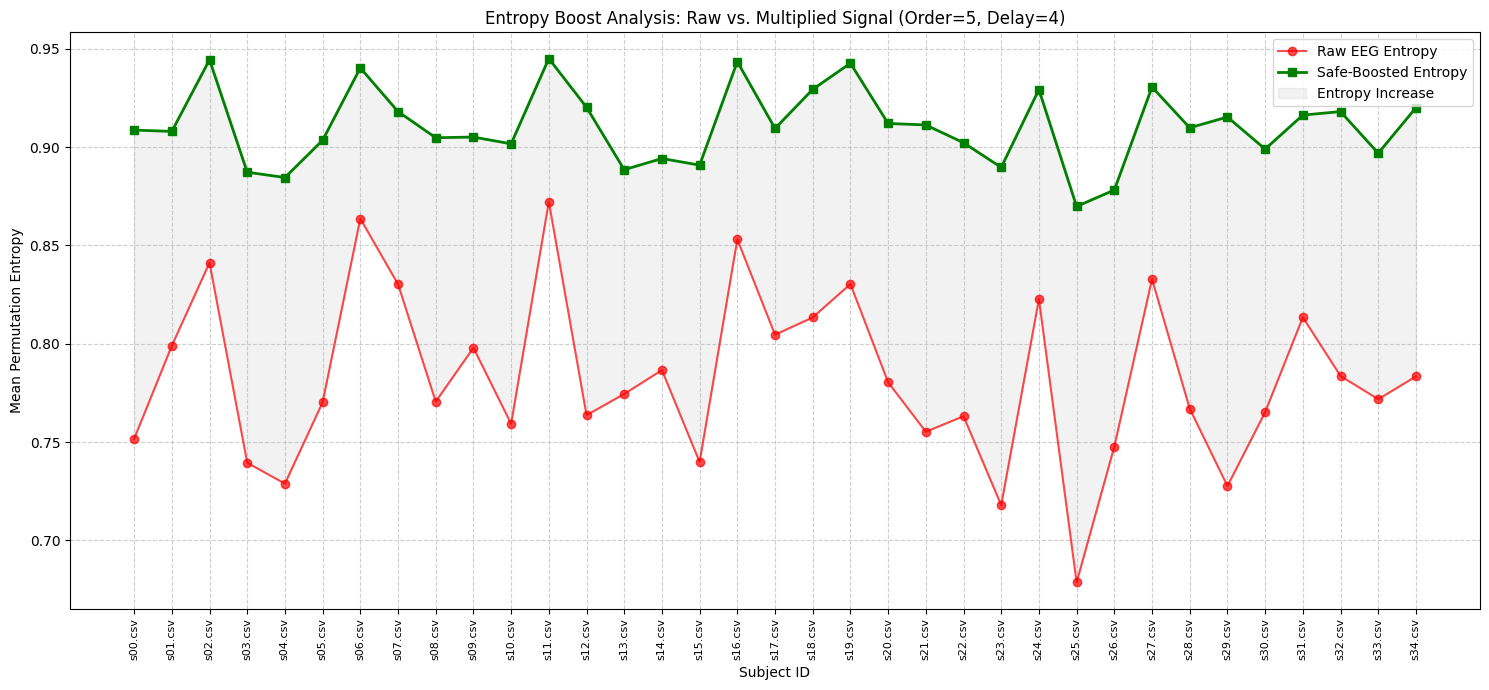


--- ENTROPY BOOST SUMMARY ---
Average Raw Entropy: 0.7829
Average Boosted Entropy: 0.9105
Total Increase: 16.30%


In [18]:
# comparison
import pandas as pd
import numpy as np
import antropy as ant
import glob
import os
import matplotlib.pyplot as plt

raw_folder = '/content'
boosted_folder = '/content/safe_boosted_eeg'
num_files = 100
ORDER = 5
DELAY = 4

raw_files = sorted(glob.glob(os.path.join(raw_folder, "s*.csv")))[:num_files]
boosted_files = sorted(glob.glob(os.path.join(boosted_folder, "safe_s*.csv")))[:num_files]

raw_means = []
boosted_means = []
subject_labels = []

print("Calculating comparison metrics...")

for i in range(len(raw_files)):
    # Process Raw File
    df_raw = pd.read_csv(raw_files[i], header=None)
    raw_pe = [ant.perm_entropy(df_raw.iloc[:, col], order=ORDER, delay=DELAY, normalize=True) for col in range(df_raw.shape[1])]
    raw_means.append(np.mean(raw_pe))
    sub_id = os.path.basename(raw_files[i])
    subject_labels.append(sub_id)

    boosted_path = os.path.join(boosted_folder, f"safe_{sub_id}")
    if os.path.exists(boosted_path):
        df_boosted = pd.read_csv(boosted_path, header=None)
        boosted_pe = [ant.perm_entropy(df_boosted.iloc[:, col], order=ORDER, delay=DELAY, normalize=True) for col in range(df_boosted.shape[1])]
        boosted_means.append(np.mean(boosted_pe))
    else:
        boosted_means.append(np.nan)

plt.figure(figsize=(15, 7))

plt.plot(subject_labels, raw_means, color='red', marker='o', label='Raw EEG Entropy', linewidth=1.5, alpha=0.7)
plt.plot(subject_labels, boosted_means, color='green', marker='s', label='Safe-Boosted Entropy', linewidth=2)

# Fill the area between to show the 'Boost' gap
plt.fill_between(range(len(subject_labels)), raw_means, boosted_means, color='gray', alpha=0.1, label='Entropy Increase')
plt.title(f'Entropy Boost Analysis: Raw vs. Multiplied Signal (Order={ORDER}, Delay={DELAY})')
plt.xlabel('Subject ID')
plt.ylabel('Mean Permutation Entropy')
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print the final average boost percentage
avg_raw = np.mean(raw_means)
avg_boost = np.mean(boosted_means)
percent_increase = ((avg_boost - avg_raw) / avg_raw) * 100

print(f"\n--- ENTROPY BOOST SUMMARY ---")
print(f"Average Raw Entropy: {avg_raw:.4f}")
print(f"Average Boosted Entropy: {avg_boost:.4f}")
print(f"Total Increase: {percent_increase:.2f}%")